In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Example: adjust source path to your real path
!cp -r "/content/drive/MyDrive/Braille" "/content/braille_dataset_local"


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
data_dir = "/content/braille_dataset_local"

mean, std = 0.5, 0.5   # grayscale mean/std placeholder; you can compute exact mean/std from dataset

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(6, expand=False),   # small rotation
    transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])



full_dataset = datasets.ImageFolder(root=data_dir)
num_classes = len(full_dataset.classes)
print("Classes:", full_dataset.classes)  # should be ['A','B',...,'Z']
print("Num classes:", num_classes)


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Num classes: 26


In [6]:
base_dataset = datasets.ImageFolder(root=data_dir)

total_len = len(base_dataset)
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_subset, val_subset = random_split(base_dataset, [train_len, val_len])


In [7]:
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

In [8]:
train_dataset = TransformSubset(train_subset, train_transform)
val_dataset = TransformSubset(val_subset, val_transform)

In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class BrailleCNN(nn.Module):
    def __init__(self, num_classes=26):
        super(BrailleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

model = BrailleCNN(num_classes=num_classes).to(device)
print(model)

BrailleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=26, bias=True)
  )
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [13]:
print("Num samples in train dataset:", len(train_dataset))
print("Num batches per epoch:", len(train_loader))


Num samples in train dataset: 9359
Num batches per epoch: 293


In [14]:
num_epochs = 20
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)

    # save history for plots
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # print log
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "braille_cnn_best.pth")

print("Best Val Acc:", best_val_acc)


Epoch [1/20] Train Loss: 1.1298 | Train Acc: 0.6938 | Val Loss: 0.2707 | Val Acc: 0.9423
Epoch [2/20] Train Loss: 0.3682 | Train Acc: 0.9018 | Val Loss: 0.1655 | Val Acc: 0.9590
Epoch [3/20] Train Loss: 0.2654 | Train Acc: 0.9274 | Val Loss: 0.1413 | Val Acc: 0.9628
Epoch [4/20] Train Loss: 0.2253 | Train Acc: 0.9341 | Val Loss: 0.1285 | Val Acc: 0.9667
Epoch [5/20] Train Loss: 0.2092 | Train Acc: 0.9407 | Val Loss: 0.1091 | Val Acc: 0.9748
Epoch [6/20] Train Loss: 0.1755 | Train Acc: 0.9472 | Val Loss: 0.0893 | Val Acc: 0.9765
Epoch [7/20] Train Loss: 0.1642 | Train Acc: 0.9514 | Val Loss: 0.0809 | Val Acc: 0.9765
Epoch [8/20] Train Loss: 0.1515 | Train Acc: 0.9529 | Val Loss: 0.0701 | Val Acc: 0.9825
Epoch [9/20] Train Loss: 0.1467 | Train Acc: 0.9547 | Val Loss: 0.0744 | Val Acc: 0.9778
Epoch [10/20] Train Loss: 0.1240 | Train Acc: 0.9629 | Val Loss: 0.0617 | Val Acc: 0.9829
Epoch [11/20] Train Loss: 0.1247 | Train Acc: 0.9617 | Val Loss: 0.0581 | Val Acc: 0.9846
Epoch [12/20] Train

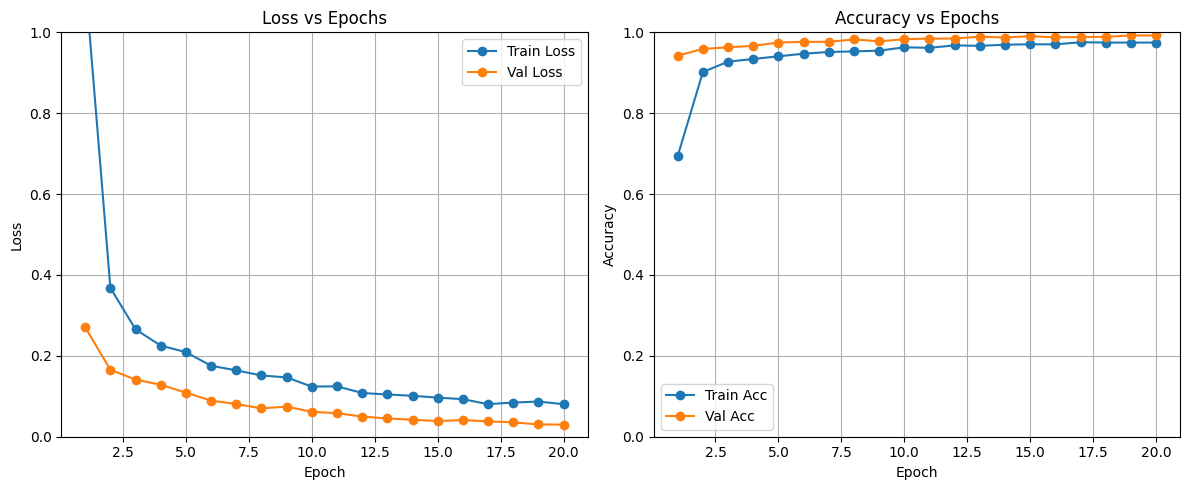

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

# ---- Loss Graph ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Make the loss y-axis bigger (zoom OUT)
plt.ylim(0, 1)              # <--- THIS pushes the lines closer

# ---- Accuracy Graph ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Train Acc')
plt.plot(epochs, val_accuracies, marker='o', label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Make the accuracy y-axis bigger (zoom OUT)
plt.ylim(0, 1)              # <--- THIS makes both curves closer visually

plt.tight_layout()
plt.show()


In [16]:
from PIL import Image, ImageOps

idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
print(idx_to_class)  # {0: 'A', 1: 'B', ...}

def preprocess_external_image(image: Image.Image) -> Image.Image:
    # 1) Convert to grayscale
    image = image.convert("L")

    # 2) Center-crop to a square (so dots are centered)
    w, h = image.size
    crop = min(w, h)
    left = (w - crop) // 2
    top = (h - crop) // 2
    image = image.crop((left, top, left + crop, top + crop))

    # 3) Normalize contrast
    image = ImageOps.autocontrast(image)

    # OPTIONAL: if your dataset has black dots on white background and
    # these icons look inverted, you can try:
    # image = ImageOps.invert(image)

    return image

def predict_image(path, model, transform, device):
    model.eval()

    # open + custom preprocessing
    image = Image.open(path)
    image = preprocess_external_image(image)

    # same transform as validation
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, pred = torch.max(outputs, 1)

    class_idx = pred.item()
    class_name = idx_to_class[class_idx]
    return class_name


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [32]:
model.load_state_dict(torch.load("braille_cnn_best.pth", map_location=device))
print(predict_image("/content/braille_dataset_local/A/Screenshot 2025-12-07 105246 - Copy.png", model, val_transform, device))

A


torch.Size([1, 64, 64])


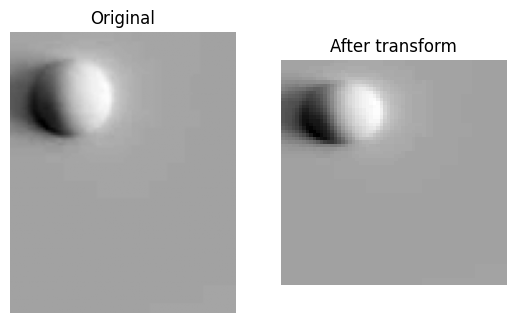

In [33]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("/content/braille_dataset_local/A/Screenshot 2025-12-07 105246 - Copy.png").convert("L")
img_t = val_transform(img)  # same val_transform you use
print(img_t.shape)          # should be [1, H, W] or [C,H,W]

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("After transform")
plt.imshow(img_t.squeeze(0), cmap="gray")
plt.axis("off")

plt.show()


In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import cv2, numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch

def segment_and_recognize_v2_debug(image_path, model, val_transform, device, idx_to_class,
                                   min_dot_area=6, max_dot_area=2000, debug=True,
                                   morph_iters=1, pad_override=None):
    """
    Deterministic Braille segmentation:
      - robust thresholding with fallback to Otsu if too noisy
      - cluster Y into 3 rows, sort by X, group every 2 columns into a cell
      - predicts each cell via `model` + `val_transform`
    Adjustable params:
      min_dot_area / max_dot_area: contour area filter
      morph_iters: morphological opening iterations (increase if noisy)
      pad_override: integer pad to expand cell bboxes (auto if None)
    """
    img_orig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_orig is None:
        raise FileNotFoundError(image_path)
    h0, w0 = img_orig.shape
    print(f"Original image size: {w0} x {h0}")

    # optional resize for stability
    scale = 1.0
    max_dim = 1200
    if max(h0, w0) > max_dim:
        scale = max_dim / max(h0, w0)
        img = cv2.resize(img_orig, (int(w0*scale), int(h0*scale)), interpolation=cv2.INTER_AREA)
    else:
        img = img_orig.copy()
    h, w = img.shape
    print(f"Working image size: {w} x {h} (scale={scale:.3f})")

    # normalize + blur + adaptive threshold (dots -> white)
    img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    blur = cv2.GaussianBlur(img_norm, (3,3), 0)
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=morph_iters)

    # quick noise check: if too many tiny contours, switch to Otsu + stronger opening
    contours_test, _ = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours_test) > 300:
        if debug:
            print(f"Adaptive threshold produced {len(contours_test)} contours — switching to Otsu fallback.")
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        th = cv2.medianBlur(th, 3)
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=max(2, morph_iters+1))

    # If dots look inverted (rare), you could invert here — but keep commented unless needed:
    # if np.sum(th==255) < 50:  # too few white pixels -> maybe inverted
    #     th = cv2.bitwise_not(th)

    if debug:
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.title("orig"); plt.axis('off'); plt.imshow(img_orig, cmap='gray')
        plt.subplot(1,3,2); plt.title("norm"); plt.axis('off'); plt.imshow(img_norm, cmap='gray')
        plt.subplot(1,3,3); plt.title("threshold (inv)"); plt.axis('off'); plt.imshow(th, cmap='gray')
        plt.show()

    # find contours -> centroids
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < min_dot_area or area > max_dot_area:
            continue
        M = cv2.moments(c)
        if M['m00'] == 0:
            continue
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx, cy))
        x,y,wc,hc = cv2.boundingRect(c)
        boxes.append((x,y,x+wc,y+hc))
    print("Found contours (total):", len(contours))
    print("Filtered centroids (after area filter):", len(centroids))

    if len(centroids) == 0:
        print("No centroids found — try lowering min_dot_area or check threshold image.")
        return "", []

    centroids = np.array(centroids)

    # ----------------------------
    # DETERMINISTIC 3-row -> 2-column pairing
    # ----------------------------
    # cluster Y into 3 rows if possible
    if len(centroids) >= 3:
        try:
            ys = centroids[:,1].reshape(-1,1)
            kmeans = KMeans(n_clusters=3, random_state=0).fit(ys)
            row_labels = kmeans.labels_
            row_centers = kmeans.cluster_centers_.reshape(-1)
            order = np.argsort(row_centers)
            mapped = np.array([ np.where(order == rl)[0][0] for rl in row_labels ])
        except Exception as e:
            print("KMeans failed, falling back to single row. Error:", e)
            mapped = np.zeros(len(centroids), dtype=int)
    else:
        mapped = np.zeros(len(centroids), dtype=int)

    # build rows
    rows = {0: [], 1: [], 2: []}
    for (cx, cy), r in zip(centroids, mapped):
        r_clamped = int(np.clip(r, 0, 2))
        rows[r_clamped].append((int(cx), int(cy)))

    # create ordered list of rows that are non-empty (top->bottom)
    non_empty_rows = [r for r in [0,1,2] if len(rows[r]) > 0]
    if len(non_empty_rows) == 0:
        print("All rows empty after filtering — aborting.")
        return "", []

    # sort each row left->right
    for r in non_empty_rows:
        rows[r] = sorted(rows[r], key=lambda p: p[0])

    # max number of dot columns in a row
    max_cols = max([len(rows[r]) for r in non_empty_rows])

    # determine pad to expand cell bbox
    if pad_override is not None:
        pad = int(pad_override)
    else:
        # auto pad: small percentage of image width but not too small
        pad = max(10, int(min(w, h) * 0.015))

    cell_bboxes = []
    col_idx = 0
    while col_idx < max_cols:
        xs = []
        ys = []
        for r in non_empty_rows:
            if col_idx < len(rows[r]):
                xs.append(rows[r][col_idx][0]); ys.append(rows[r][col_idx][1])
            if (col_idx + 1) < len(rows[r]):
                xs.append(rows[r][col_idx+1][0]); ys.append(rows[r][col_idx+1][1])
        if len(xs) == 0:
            col_idx += 2
            continue

        x1 = max(min(xs) - pad, 0)
        x2 = min(max(xs) + pad, w)
        y1 = max(min(ys) - pad, 0)
        y2 = min(max(ys) + pad, h)

        cell_bboxes.append((x1, y1, x2, y2))
        col_idx += 2

    # fallback: if no cells, try agglomerative as last resort (keeps old behavior)
    if len(cell_bboxes) == 0:
        print("Deterministic pairing produced 0 cells; falling back to agglomerative pairing.")
        x_coords = centroids[:,0].reshape(-1,1)
        xs_sorted = np.sort(centroids[:,0])
        median_x_gap = int(np.median(np.diff(xs_sorted)) if len(xs_sorted)>1 else max(10, w/10))
        dist_thresh = max(int(median_x_gap * 0.9), 10)
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist_thresh, linkage='single').fit(x_coords)
        col_labels = clustering.labels_
        col_groups = {}
        for label, (cx, cy), rlabel in zip(col_labels, centroids, mapped):
            col_groups.setdefault(label, []).append((int(cx), int(cy), int(rlabel)))
        col_info = []
        for label, pts in col_groups.items():
            xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
            x_center = int(np.mean(xs))
            x1 = max(0, min(xs) - int(median_x_gap * 0.6))
            x2 = min(w, max(xs) + int(median_x_gap * 0.6))
            y1 = max(0, min(ys) - int(median_x_gap * 0.6))
            y2 = min(h, max(ys) + int(median_x_gap * 0.6))
            col_info.append((label, x_center, (x1, y1, x2, y2), pts))
        col_info = sorted(col_info, key=lambda c: c[1])
        i = 0
        while i < len(col_info):
            if i+1 < len(col_info):
                xc1 = col_info[i][1]; xc2 = col_info[i+1][1]
                if (xc2 - xc1) < max(int(median_x_gap * 2.2), 60):
                    bbox1 = col_info[i][2]; bbox2 = col_info[i+1][2]
                    x1 = min(bbox1[0], bbox2[0]); y1 = min(bbox1[1], bbox2[1])
                    x2 = max(bbox1[2], bbox2[2]); y2 = max(bbox1[3], bbox2[3])
                    cell_bboxes.append((x1,y1,x2,y2))
                    i += 2
                else:
                    cell_bboxes.append(col_info[i][2])
                    i += 1
            else:
                cell_bboxes.append(col_info[i][2])
                i += 1

    # scale back to original coordinates if needed
    if scale != 1.0:
        inv = 1.0/scale
        cell_bboxes = [ (int(x1*inv), int(y1*inv), int(x2*inv), int(y2*inv)) for (x1,y1,x2,y2) in cell_bboxes ]

    print("Number of cell bboxes after pairing:", len(cell_bboxes))
    if debug:
        vis2 = cv2.cvtColor(img_orig.copy(), cv2.COLOR_GRAY2BGR)
        for (x1,y1,x2,y2) in cell_bboxes:
            cv2.rectangle(vis2, (x1,y1), (x2,y2), (0,255,0), 2)
        plt.figure(figsize=(10,3)); plt.imshow(vis2[:,:,::-1]); plt.title("Final cell bboxes (orig scale)"); plt.axis('off'); plt.show()

    # now predict each crop
    tokens = []
    crops = []
    for (x1,y1,x2,y2) in cell_bboxes:
        crop = img_orig[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        pil = Image.fromarray(crop).convert("L")
        pil = ImageOps.autocontrast(pil)
        input_t = val_transform(pil).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(input_t)
            _, pred = torch.max(out, 1)
        token = idx_to_class[pred.item()]
        tokens.append(token)
        crops.append((pil, token))

    # show crops & per-crop prediction for debug
    if debug:
        n = len(crops)
        if n > 0:
            cols = min(8, n)
            rows = (n + cols - 1)//cols
            plt.figure(figsize=(cols*2, rows*2))
            for i, (pil, token) in enumerate(crops):
                plt.subplot(rows, cols, i+1)
                plt.imshow(pil, cmap='gray'); plt.title(token); plt.axis('off')
            plt.show()
        else:
            print("No crops produced — check bboxes or scale/coordinates.")

    # join tokens and add spaces on big gaps
    x_centers = [ (b[0]+b[2])//2 for b in cell_bboxes ] if len(cell_bboxes)>0 else []
    gaps = [x_centers[i+1] - x_centers[i] for i in range(len(x_centers)-1)] if len(x_centers)>1 else []
    median_gap = int(np.median(gaps)) if len(gaps)>0 else 0

    final_tokens = []
    for i, t in enumerate(tokens):
        final_tokens.append(t)
        if i < len(gaps) and median_gap>0 and gaps[i] > 1.9 * median_gap:
            final_tokens.append(" ")

    result_text = "".join(final_tokens).strip()
    print("Final predicted text:", result_text)
    return result_text, cell_bboxes, centroids, (th, img, img_orig)


Original image size: 171 x 90
Working image size: 171 x 90 (scale=1.000)


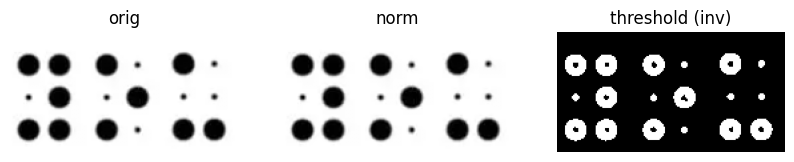

Found contours (total): 18
Filtered centroids (after area filter): 18
Number of cell bboxes after pairing: 3


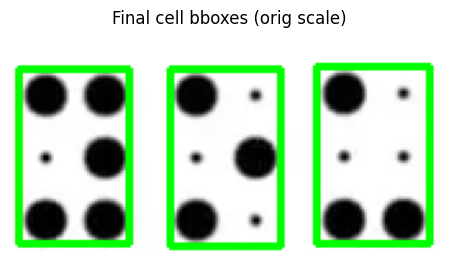

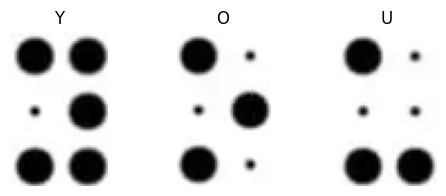

Final predicted text: YOU


In [40]:
res = segment_and_recognize_v2_debug("/content/Screenshot 2025-12-04 144536.png",
                                     model, val_transform, device, idx_to_class,
                                     min_dot_area=6, max_dot_area=2000, debug=True,
                                     morph_iters=1)
